In [1]:
import sys
import gym
import torch
import pylab
import random
import numpy as np
from collections import deque
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms
from prioritized_memory import Memory

In [2]:
seed = 161
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
EPISODES = 500

In [4]:
# approximate Q function using Neural Network
# state is input and Q Value of each action is output of network
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, action_size)
        )

    def forward(self, x):
        return self.fc(x)

In [5]:
# DQN Agent for the Cartpole
# it uses Neural Network to approximate q function
# and prioritized experience replay memory & target q network
class DQNAgent():
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False

        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.memory_size = 20000
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.explore_step = 5000
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / self.explore_step
        self.batch_size = 64
        self.train_start = 1000

        # create prioritized replay memory using SumTree
        self.memory = Memory(self.memory_size)

        # create main model and target model
        self.model = DQN(state_size, action_size)
        self.model.apply(self.weights_init)
        self.target_model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(),
                                    lr=self.learning_rate)

        # initialize target model
        self.update_target_model()
        
        self.loss_func = nn.MSELoss(reduce=False)
        
        if self.load_model:
            self.model = torch.load('save_model/cartpole_dqn')

    # weight xavier initialize
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            torch.nn.init.xavier_uniform(m.weight)

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    # get action from model using epsilon-greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state = torch.from_numpy(state)
            state = Variable(state).float().cpu()
            q_value = self.model(state)
            _, action = torch.max(q_value, 1)
            return int(action)

    # save sample (error,<s,a,r,s'>) to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        target = self.model(Variable(torch.FloatTensor(state))).data
        old_val = target[0][action]
        target_val = self.target_model(Variable(torch.FloatTensor(next_state))).data
        if done:
            target[0][action] = reward
        else:
            target[0][action] = reward + self.discount_factor * torch.max(target_val)

        error = abs(old_val - target[0][action])

        self.memory.add(error, (state, action, reward, next_state, done))

    # pick samples from prioritized replay memory (with batch_size)
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay

        mini_batch, idxs, is_weights = self.memory.sample(self.batch_size)
        mini_batch = np.array(mini_batch).transpose()

        states = np.vstack(mini_batch[0])
        actions = list(mini_batch[1])
        rewards = list(mini_batch[2])
        next_states = np.vstack(mini_batch[3])
        dones = mini_batch[4]

        # bool to binary
        dones = dones.astype(int)

        # Q function of current state
        states = torch.Tensor(states)
        states = Variable(states).float()
        pred = self.model(states)

        # one-hot encoding
        a = torch.LongTensor(actions).view(-1, 1)

        one_hot_action = torch.FloatTensor(self.batch_size, self.action_size).zero_()
        one_hot_action.scatter_(1, a, 1)

        pred = torch.sum(pred.mul(Variable(one_hot_action)), dim=1)

        # Q function of next state
        next_states = torch.Tensor(next_states)
        next_states = Variable(next_states).float()
        next_pred = self.target_model(next_states).data

        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        # Q Learning: get maximum Q value at s' from target model
        target = rewards + (1 - dones) * self.discount_factor * next_pred.max(1)[0]
        target = Variable(target)

        errors = torch.abs(pred - target).data.numpy()

        # update priority
        for i in range(self.batch_size):
            idx = idxs[i]
            self.memory.update(idx, errors[i])

        self.optimizer.zero_grad()

        # MSE Loss function
        loss = self.loss_func(pred, target)*torch.from_numpy(is_weights).float()
        
#         loss = F.mse_loss(pred, target,reduction='none')
#         *torch.from_numpy(is_weights).float()
        loss.mean().backward()

        # and train
        self.optimizer.step()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


EPISODE#   0 | SCORE:     14 | MEMORY_LENGTH:         16 | EPSILON:  1.000
EPISODE#   1 | SCORE:     10 | MEMORY_LENGTH:         28 | EPSILON:  1.000
EPISODE#   2 | SCORE:     32 | MEMORY_LENGTH:         62 | EPSILON:  1.000
EPISODE#   3 | SCORE:     34 | MEMORY_LENGTH:         98 | EPSILON:  1.000
EPISODE#   4 | SCORE:     41 | MEMORY_LENGTH:        141 | EPSILON:  1.000
EPISODE#   5 | SCORE:     21 | MEMORY_LENGTH:        164 | EPSILON:  1.000
EPISODE#   6 | SCORE:     29 | MEMORY_LENGTH:        195 | EPSILON:  1.000
EPISODE#   7 | SCORE:     44 | MEMORY_LENGTH:        241 | EPSILON:  1.000
EPISODE#   8 | SCORE:     12 | MEMORY_LENGTH:        255 | EPSILON:  1.000
EPISODE#   9 | SCORE:     31 | MEMORY_LENGTH:        288 | EPSILON:  1.000
EPISODE#  10 | SCORE:     20 | MEMORY_LENGTH:        310 | EPSILON:  1.000
EPISODE#  11 | SCORE:     24 | MEMORY_LENGTH:        336 | EPSILON:  1.000
EPISODE#  12 | SCORE:     91 | MEMORY_LENGTH:        429 | EPSILON:  1.000
EPISODE#  13 | SCORE:    

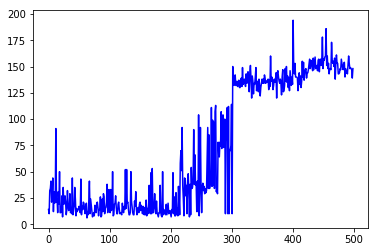

In [6]:
# In case of CartPole-v1, maximum length of episode is 500
env = gym.make('CartPole-v1')
env.seed(seed)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
model = DQN(state_size, action_size)

agent = DQNAgent(state_size, action_size)
scores, episodes = [], []

for e in range(EPISODES):
    done = False
    score = 0

    state = env.reset()
    state = np.reshape(state, [1, state_size])

    while not done:
        if agent.render:
            env.render()

        # get action for the current state and go one step in environment
        action = agent.get_action(state)

        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        # if an action make the episode end, then gives penalty of -100
        reward = reward if not done or score == 499 else -1

        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, done)
        # every time step do the training
        if agent.memory.tree.n_entries >= agent.train_start:
            agent.train_model()

        score += reward
        state = next_state

        if done:
            # every episode update the target model to be same with model
            TARGET_REPLACE_ITER = 100
            if(e%TARGET_REPLACE_ITER == 0):
                agent.update_target_model()

            # every episode, plot the play time
#             score = score if score == 500 else score + 10
            scores.append(score)
            episodes.append(e)
#             pylab.plot(episodes, scores, 'b')
#             pylab.savefig("./save_graph/cartpole_dqn.png")
#             print("episode:", e, "  score:", score, "  memory length:", agent.memory.tree.n_entries, "  epsilon:", agent.epsilon)
            print("EPISODE#{:4d} | SCORE: {:6d} | MEMORY_LENGTH: {:10d} | EPSILON: {:6.3f}".format(int(e), int(score), int(agent.memory.tree.n_entries), agent.epsilon))

            # if the mean of scores of last 10 episode is bigger than 490
            # stop training
#             if np.mean(scores[-min(10, len(scores)):]) > 490:
#                 torch.save(agent.model, "./save_model/cartpole_dqn")
#                 sys.exit()
#                 break

pylab.plot(episodes, scores, 'b')